In [131]:
import csv
import pandas as pd
import nltk
import time
import numpy as np
import string, re
import seaborn as sns
from collections import Counter
nltk.download('words')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package words to /Users/andrewlin/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/andrewlin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Data Preprocessing

In [ ]:
# Import Song Data

song_data = pd.read_csv('./data/lyrics-data.csv')
english_songs = song_data.loc[song_data['language'] == 'en']
english_songs.rename(columns={'ALink':'Link'}, inplace=True)
english_songs.head()

In [ ]:
# Import Artist Data

artist_data = pd.read_csv('./data/artists-data.csv')
artist_data = artist_data.drop_duplicates(subset='Link', keep='first')
artist_data.head()

In [ ]:
# Merge Dataframes

combined_data = pd.merge(english_songs, artist_data, on='Link')
combined_data = combined_data[["SName", "Artist", "Lyric", "Genres"]]
combined_data = combined_data[combined_data.Lyric.notnull()]
combined_data = combined_data[combined_data.Genres.notnull()]
combined_data

In [ ]:
artists = combined_data.Artist.unique()
genres = combined_data.Genres.unique()
labels = ["Blues", "Country", "Hip Hop", "Jazz", "Pop", "Rock"]

In [ ]:
# Randomely select 1000 songs from each genre

rows = []

for label in labels:
    genre_data = combined_data[combined_data.Genres == label]
    genre_data = genre_data.sample(n=1000, replace=False)
    genre_data.Genres = label
    rows.append(genre_data)

combined_genre_data = pd.concat(rows).reset_index().drop("index", axis=1)
combined_genre_data

In [ ]:
combined_genre_data.to_csv("combined_genre_data.csv")

## Reload the data

In [4]:
combined_genre_data = pd.read_csv("combined_genre_data.csv")
combined_genre_data.head()

,Unnamed: 0,SName,Artist,Lyric,Genres
0,0,Country Boy,Muddy Waters,Don't say I don't love you\nBecause I stays ou...,Blues
1,1,Don't Wait 'til Tomorrow,Gary Clark Jr.,I'm so tired of fighting\nI'm so tired of bein...,Blues
2,2,Frankie,Mississippi John Hurt,"(spoken introduction:\n""Frankie and Albert"", t...",Blues
3,3,Fear Of Falling,The Allman Brothers Band,"by G. Allman, J. Townsend & T. Heding\nThere w...",Blues
4,4,I've Always Been Lonely,BB King,I don't have to know your name\nUnless you rea...,Blues


In [147]:
def train_and_pipeline(lyrics):
    X = lyrics
    y = combined_genre_data.Genres
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
    
    pipe_MNB = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', MultinomialNB())
                       ])
    
    pipe_CNB = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', ComplementNB())
                       ])

    pipe_RF = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', RandomForestClassifier())
                       ])

    pipe_KNN = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                        ('clf', KNeighborsClassifier())
                        ])

    # List of pipelines, List of pipeline names
    pipelines = [pipe_MNB, pipe_CNB, pipe_RF, pipe_KNN]
    pipeline_names = ['Multinomail NB', 'Complement NB', 'Random Forest', "KNN"]

    # Loop to fit each of the three pipelines
    for pipe in pipelines:
        print(pipe)
        pipe.fit(X_train, y_train)

    # Compare accuracies
    lemmed_basic_scores = []
    for index, val in enumerate(pipelines):
        tup = (pipeline_names[index], val.score(X_test, y_test))
        lemmed_basic_scores.append(tup)
        print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))
        
    return lemmed_basic_scores

In [74]:
results = Counter()
lyrics_list = list(combined_genre_data.Lyric)
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
lemmatizer = WordNetLemmatizer()
english = list(set(nltk.corpus.words.words()))
stemmer = SnowballStemmer("english")

# Lemmatization

In [10]:
def clean_docs_lemma(lyrics_list):
    cleaned = []
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_lemmas = [lemmatizer.lemmatize(word) for word in lyrics_tokens_stopped]
        c = " ".join(lyric_lemmas)
        cleaned.append(c)
    return cleaned

In [11]:
lemmed_lyrics = clean_docs_lemma(lyrics_list)
len(lemmed_lyrics)

6000

In [33]:
lyrics_lengths = [len(lyrics) for lyrics in lemmed_lyrics]

Text(0.5, 8.95999999999998, 'Number of Lyrics')

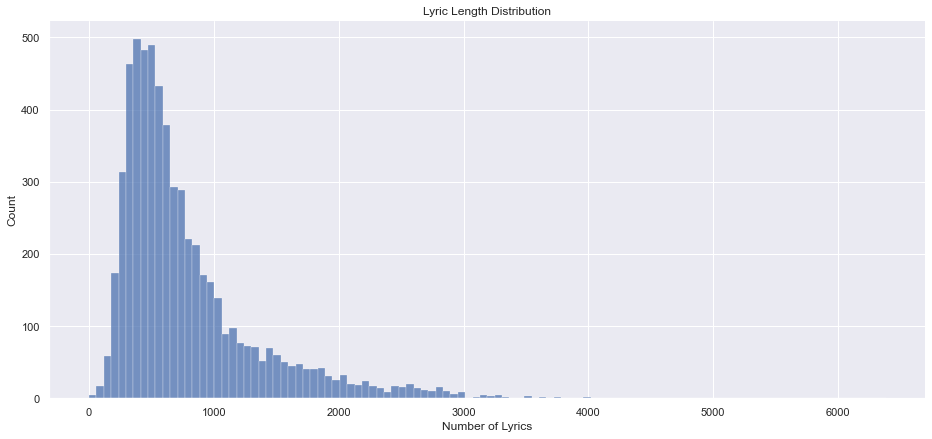

In [54]:
sns.displot(lyrics_lengths)
plt.gcf().set_size_inches(15, 6)
plt.title("Lyric Length Distribution")
plt.xlabel("Number of Lyrics")

In [135]:
results["lemmed"] = train_and_pipeline(lemmed_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.597
Complement NB pipeline test accuracy: 0.609
Random Forest pipeline test accuracy: 0.605
KNN pipeline test accuracy: 0.367


# Stemming

In [55]:
def clean_docs_stemma(lyrics_list):
    cleaned = []
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_stemmas = [stemmer.stem(word) for word in lyrics_tokens_stopped]
        c = " ".join(lyric_stemmas)
        cleaned.append(c)
    return cleaned

In [56]:
stemmed_lyrics = clean_docs_stemma(lyrics_list)

In [136]:
results["stemmed"] = train_and_pipeline(stemmed_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.560
Complement NB pipeline test accuracy: 0.587
Random Forest pipeline test accuracy: 0.571
KNN pipeline test accuracy: 0.380


# Stemmed & Lemmatized

In [64]:
lemmatized_stemmed_lyrics = clean_docs_lemma(stemmed_lyrics)

In [137]:
results["lemmatized_stemmed"] = train_and_pipeline(lemmatized_stemmed_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.588
Complement NB pipeline test accuracy: 0.598
Random Forest pipeline test accuracy: 0.575
KNN pipeline test accuracy: 0.380


In [66]:
stemmed_lemmatized_lyrics = clean_docs_lemma(lemmed_lyrics)

In [138]:
results["stemmed_lemmatized"] = train_and_pipeline(stemmed_lemmatized_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.592
Complement NB pipeline test accuracy: 0.603
Random Forest pipeline test accuracy: 0.594
KNN pipeline test accuracy: 0.383


In [139]:
results

Counter({'stemmed': [('Multinomail NB', 0.56),
          ('Complement NB', 0.5866666666666667),
          ('Random Forest', 0.5706666666666667),
          ('KNN', 0.38)],
         'lemmatized_stemmed': [('Multinomail NB', 0.588),
          ('Complement NB', 0.598),
          ('Random Forest', 0.5746666666666667),
          ('KNN', 0.38)],
         'stemmed_lemmatized': [('Multinomail NB', 0.592),
          ('Complement NB', 0.6026666666666667),
          ('Random Forest', 0.594),
          ('KNN', 0.38266666666666665)],
         'lemmed': [('Multinomail NB', 0.5973333333333334),
          ('Complement NB', 0.6093333333333333),
          ('Random Forest', 0.6046666666666667),
          ('KNN', 0.36733333333333335)]})

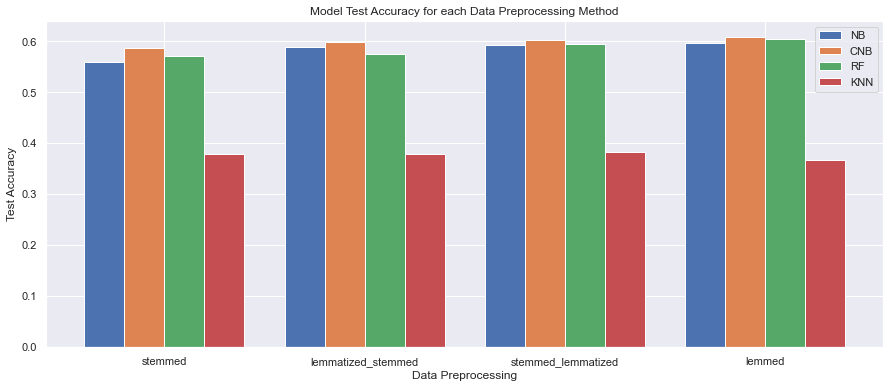

In [146]:
X = results.keys()

MNB = [results[x][0][1] for x in X]
CNB = [results[x][1][1] for x in X]
RF = [results[x][2][1] for x in X]
KNN = [results[x][3][1] for x in X]

X_axis = np.arange(len(X))
plt.bar(X_axis - 0.3, MNB, 0.2, label = 'NB')
plt.bar(X_axis - 0.1, CNB, 0.2, label = 'CNB')
plt.bar(X_axis + 0.1, RF, 0.2, label = 'RF')
plt.bar(X_axis + 0.3, KNN, 0.2, label = 'KNN')

plt.xticks(X_axis, X)

plt.gcf().set_size_inches(15, 6)
plt.xlabel("Data Preprocessing")
plt.ylabel('Test Accuracy')
plt.title("Model Test Accuracy for each Data Preprocessing Method")
plt.legend()
plt.show()

# Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier()

In [26]:
GS_pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

rf_param_grid = dict(clf__n_estimators = [10, 30, 100],
                  clf__criterion = ['gini', 'entropy'],
                  clf__max_depth = [2, 6, 10], 
                  clf__min_samples_split = [5, 10],
                  clf__min_samples_leaf = [3, 6])


gs_RF = GridSearchCV(estimator=GS_pipe_RF,
            param_grid=rf_param_grid,
            scoring='accuracy',
            cv=3)

gs_RF.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                                       ('tfidf_vectorizer', TfidfTransformer()),
                                       ('clf', RandomForestClassifier())]),
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [2, 6, 10],
                         'clf__min_samples_leaf': [3, 6],
                         'clf__min_samples_split': [5, 10],
                         'clf__n_estimators': [10, 30, 100]},
             scoring='accuracy')

In [27]:
rf_gs_testing_score = gs_RF.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(rf_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_RF.best_params_))

Mean Testing Score: 51.73%
Best Parameter Combination Found During Grid Search: 
{'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 10, 'clf__n_estimators': 100}


# Naive Bayes

In [28]:
GS_pipe_NB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])


sorted(GS_pipe_NB.get_params().keys())

nb_param_grid = dict(clf__alpha = [.01, .05, .1, .2, .4, 1])

gs_NB = GridSearchCV(estimator=GS_pipe_NB,
            param_grid=nb_param_grid,
            scoring='accuracy',
            cv=3)

gs_NB.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                                       ('tfidf_vectorizer', TfidfTransformer()),
                                       ('clf', MultinomialNB())]),
             param_grid={'clf__alpha': [0.01, 0.05, 0.1, 0.2, 0.4, 1]},
             scoring='accuracy')

In [29]:
nb_gs_testing_score = gs_NB.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(nb_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_NB.best_params_))

Mean Testing Score: 61.27%
Best Parameter Combination Found During Grid Search: 
{'clf__alpha': 0.05}


# KNN Classifier

In [30]:
GS_pipe_KNN = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', KNeighborsClassifier())
                    ])

knn_param_grid = dict(clf__n_neighbors = [100, 150, 200],
                     clf__p = [1, 2])

gs_KNN = GridSearchCV(estimator=GS_pipe_KNN,
            param_grid=knn_param_grid,
            scoring='accuracy',
            cv=3)

gs_KNN.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                                       ('tfidf_vectorizer', TfidfTransformer()),
                                       ('clf', KNeighborsClassifier())]),
             param_grid={'clf__n_neighbors': [100, 150, 200], 'clf__p': [1, 2]},
             scoring='accuracy')

In [31]:
knn_gs_testing_score = gs_KNN.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(knn_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_KNN.best_params_))

Mean Testing Score: 49.2%
Best Parameter Combination Found During Grid Search: 
{'clf__n_neighbors': 200, 'clf__p': 2}
